# Práctica 1, Sesión 3: Modelos lineales generativos

**Notación:** $\quad\boldsymbol{x}\in\mathbb{R}^D\;$ y $\;y\in\{1,\dotsc,C\}\;$ salvo que se indique otra cosa

**Clasificador generativo:** $\;$ expresa **posteriors** en función de **priors** y **densidades condicionales** de las clases, las cuales puede muestrearse para **generar** datos sintéticos
$$p(y=c\mid\boldsymbol{x},\boldsymbol{\theta})=\frac{p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta})\,p(y=c,\boldsymbol{\theta})}{\sum_{c'}p(\boldsymbol{x}\mid y=c',\boldsymbol{\theta})\,p(y=c',\boldsymbol{\theta})}%
\propto p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta})\,p(y=c,\boldsymbol{\theta})$$

**Linealidad:** $\;$ la log-posterior suele ser lineal con $\boldsymbol{x},\,$ aunque en algunos es cuadrática

**Ajuste:** $\;$ la máximización de la log-verosimilitud conjunta suele conducir a estimadores fáciles de calcular mediante conteo y promediado
* Los priors de las clases se estiman como frecuencias relativas, $\,\hat{\pi}_c=N_c/N$
* Los parámetros de cada clase se estiman con sus datos de entrenamiento (salvo $\mathbf{\Sigma}$ en LDA, que se estima con todos)

## 1. Naive Bayes

**Clasificador naive Bayes Gaussiano (GNB):** $\;\boldsymbol{\theta}_c=(\boldsymbol{\theta}_{c1},\dotsc,\boldsymbol{\theta}_{cD})^t,\,\boldsymbol{\theta}_{cd}=(\mu_{cd},\sigma_{cd}^2),\,$ media y varianza de la característica $d$ en $c$
$$p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)=\prod_{d=1}^D \mathcal{N}(x_d\mid\mu_{cd},\sigma_{cd}^2)%
\qquad\text{con}\qquad%
\hat{\mu}_{cd}=\frac{1}{N_c}\sum_{n:y_n=c}x_{nd}\quad\text{y}\quad%
\hat{\sigma}_{cd}^2=\frac{1}{N_c}\sum_{n:y_n=c}(x_{nd}-\hat{\mu}_{cd})^2$$

**Aplicación a iris:** $\;$ con suavizado de varianzas añadiendo un porcentaje, `var_smoothing`, de la mayor varianza empírica hallada (1e-9 por omisión)

In [1]:
import warnings; warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris; from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB; from sklearn.metrics import accuracy_score
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
clf = GaussianNB(var_smoothing=1e-9).fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test)); print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de GaussianNB() es 93.3%


**Ejercicio:** $\;$ estudia el efecto de `var_smoothing` sobre la precisión de GNB

**Solución:**

In [2]:
for v in [1e-9, 1e-3, 1e-2, 1e-1, 2e-1]:
    clf = GaussianNB(var_smoothing=v).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de GaussianNB() es 93.3%
La precisión de GaussianNB(var_smoothing=0.001) es 93.3%
La precisión de GaussianNB(var_smoothing=0.01) es 93.3%
La precisión de GaussianNB(var_smoothing=0.1) es 86.7%
La precisión de GaussianNB(var_smoothing=0.2) es 86.7%


**Ejercicio:** $\;$ estudia el efecto de `var_smoothing` sobre la precisión de GNB en digits y olivetti

**Solución:**

In [3]:
from sklearn.datasets import load_digits; X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
for v in [1e-9, 1e-3, 1e-2, 1e-1, 2e-1]:
    clf = GaussianNB(var_smoothing=v).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de GaussianNB() es 83.6%
La precisión de GaussianNB(var_smoothing=0.001) es 89.7%
La precisión de GaussianNB(var_smoothing=0.01) es 92.5%
La precisión de GaussianNB(var_smoothing=0.1) es 91.9%
La precisión de GaussianNB(var_smoothing=0.2) es 91.7%


In [4]:
from sklearn.datasets import fetch_olivetti_faces; X, y = fetch_olivetti_faces(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
for v in [1e-9, 1e-3, 1e-2, 1e-1, 2e-1]:
    clf = GaussianNB(var_smoothing=v).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de GaussianNB() es 85.0%
La precisión de GaussianNB(var_smoothing=0.001) es 87.5%
La precisión de GaussianNB(var_smoothing=0.01) es 86.2%
La precisión de GaussianNB(var_smoothing=0.1) es 90.0%
La precisión de GaussianNB(var_smoothing=0.2) es 87.5%


## 2. Análisis discriminante lineal (LDA)

**LDA:** $\;\boldsymbol{\theta}_c=(\boldsymbol{\mu}_c^t,\,\operatorname{vec}(\mathbf{\Sigma}))^t,\,$ media de la clase $c$ y matriz de varianzas común para todas las clases
$$p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)=\mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma})
\qquad\text{con}\qquad%
\hat{\boldsymbol{\mu}}_c=\frac{1}{N_c}\sum_{n:y_n=c}\boldsymbol{x}_n\quad\text{y}\quad%
\hat{\mathbf{\Sigma}}=\frac{1}{N}\sum_c\sum_{n:y_n=c}(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)^t$$

**Aplicación a iris:** $\;$ con suavizado de la matriz de varianzas mediante un parámetro `tol` que controla su fuerza (1e-4 por omisión)

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris; X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
clf = LinearDiscriminantAnalysis(tol=1e-4).fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test)); print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de LinearDiscriminantAnalysis() es 96.7%


**Ejercicio:** $\;$ estudia el efecto de `tol` sobre la precisión de LDA en iris, digits y olivetti

**Solución:**

In [6]:
for tol in [1e-4, 1e-3, 1e-2, 1e-1, 2e-1]:
    clf = LinearDiscriminantAnalysis(tol=tol).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de LinearDiscriminantAnalysis() es 96.7%
La precisión de LinearDiscriminantAnalysis(tol=0.001) es 96.7%
La precisión de LinearDiscriminantAnalysis(tol=0.01) es 96.7%
La precisión de LinearDiscriminantAnalysis(tol=0.1) es 96.7%
La precisión de LinearDiscriminantAnalysis(tol=0.2) es 96.7%


In [7]:
from sklearn.datasets import load_digits; X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
for tol in [1e-4, 1e-3, 1e-2, 1e-1, 2e-1]:
    clf = LinearDiscriminantAnalysis(tol=tol).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de LinearDiscriminantAnalysis() es 95.0%
La precisión de LinearDiscriminantAnalysis(tol=0.001) es 95.0%
La precisión de LinearDiscriminantAnalysis(tol=0.01) es 95.0%
La precisión de LinearDiscriminantAnalysis(tol=0.1) es 95.0%
La precisión de LinearDiscriminantAnalysis(tol=0.2) es 95.0%


In [8]:
from sklearn.datasets import fetch_olivetti_faces; X, y = fetch_olivetti_faces(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
for tol in [1e-4, 1e-3, 1e-2, 1e-1, 2e-1]:
    clf = LinearDiscriminantAnalysis(tol=tol).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de LinearDiscriminantAnalysis() es 98.8%
La precisión de LinearDiscriminantAnalysis(tol=0.001) es 98.8%
La precisión de LinearDiscriminantAnalysis(tol=0.01) es 98.8%
La precisión de LinearDiscriminantAnalysis(tol=0.1) es 98.8%
La precisión de LinearDiscriminantAnalysis(tol=0.2) es 98.8%


## 3. Análisis discriminante cuadrático (QDA)

**QDA:** $\;\boldsymbol{\theta}_c=(\boldsymbol{\mu}_c^t,\,\operatorname{vec}(\mathbf{\Sigma}_c))^t,\,$ media y matriz de varianzas de la clase $c$
$$p(\boldsymbol{x}\mid y=c,\boldsymbol{\theta}_c)=\mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma}_c)
\qquad\text{con}\qquad%
\hat{\boldsymbol{\mu}}_c=\frac{1}{N_c}\sum_{n:y_n=c}\boldsymbol{x}_n\quad\text{y}\quad%
\hat{\mathbf{\Sigma}}_c=\frac{1}{N_c}\sum_{n:y_n=c}(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)^t$$

**Aplicación a iris:** $\;$ `reg_param` suaviza matrices de varianzas mediante interpolación con $\mathbf{I}$ (0, valor por omisión, no suaviza; 1 identidad)

In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.datasets import load_iris; from sklearn.model_selection import train_test_split
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
clf = QuadraticDiscriminantAnalysis(reg_param=0.0).fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test)); print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de QuadraticDiscriminantAnalysis() es 96.7%


**Ejercicio:** $\;$ estudia el efecto de `reg_param` sobre la precisión de QDA en iris, digits y olivetti

**Solución:**

In [10]:
for reg_param in [1e-2, .1, .5, .9, 1]:
    clf = QuadraticDiscriminantAnalysis(reg_param=reg_param).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de QuadraticDiscriminantAnalysis(reg_param=0.01) es 96.7%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.1) es 93.3%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.5) es 93.3%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.9) es 90.0%
La precisión de QuadraticDiscriminantAnalysis(reg_param=1) es 90.0%


In [11]:
from sklearn.datasets import load_digits; X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
for reg_param in [1e-2, .1, .5, .9, 1]:
    clf = QuadraticDiscriminantAnalysis(reg_param=reg_param).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de QuadraticDiscriminantAnalysis(reg_param=0.01) es 95.6%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.1) es 96.7%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.5) es 99.4%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.9) es 99.7%
La precisión de QuadraticDiscriminantAnalysis(reg_param=1) es 89.2%


In [12]:
from sklearn.datasets import fetch_olivetti_faces; X, y = fetch_olivetti_faces(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)
for reg_param in [1e-2, .1, .5, .9, 1]:
    clf = QuadraticDiscriminantAnalysis(reg_param=reg_param).fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f'La precisión de {clf!s} es {acc:.1%}')

La precisión de QuadraticDiscriminantAnalysis(reg_param=0.01) es 13.8%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.1) es 6.2%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.5) es 1.2%
La precisión de QuadraticDiscriminantAnalysis(reg_param=0.9) es 2.5%
La precisión de QuadraticDiscriminantAnalysis(reg_param=1) es 2.5%


## 4. Generación de datos sintéticos (opcional)

**digits:** $\;$ QDA con `reg_param=0.9` obtiene un $99.7\%$ de precisión

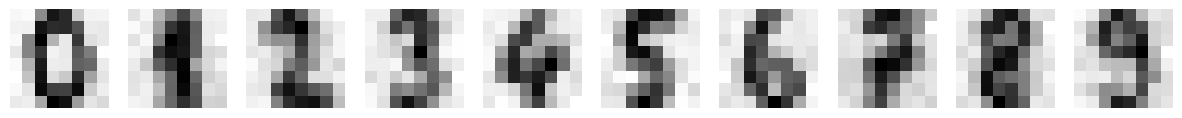

In [13]:
import matplotlib.pyplot as plt; from scipy.stats import multivariate_normal
from sklearn.datasets import load_digits; X, y = load_digits(return_X_y=True)
clf = QuadraticDiscriminantAnalysis(reg_param=0.9, store_covariance=True).fit(X, y)
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax = axs[i]; ax.set_axis_off()
    Z = multivariate_normal(mean=clf.means_[i], cov=clf.covariance_[i], seed=23).rvs(1)
    ax.imshow(Z.reshape(8,8), cmap=plt.cm.gray_r, interpolation="none")

**Ejercicio:** $\;$ genera caras sintéticas con olivetti y LDA ($98.8\%$ de acierto)


**Solución:**

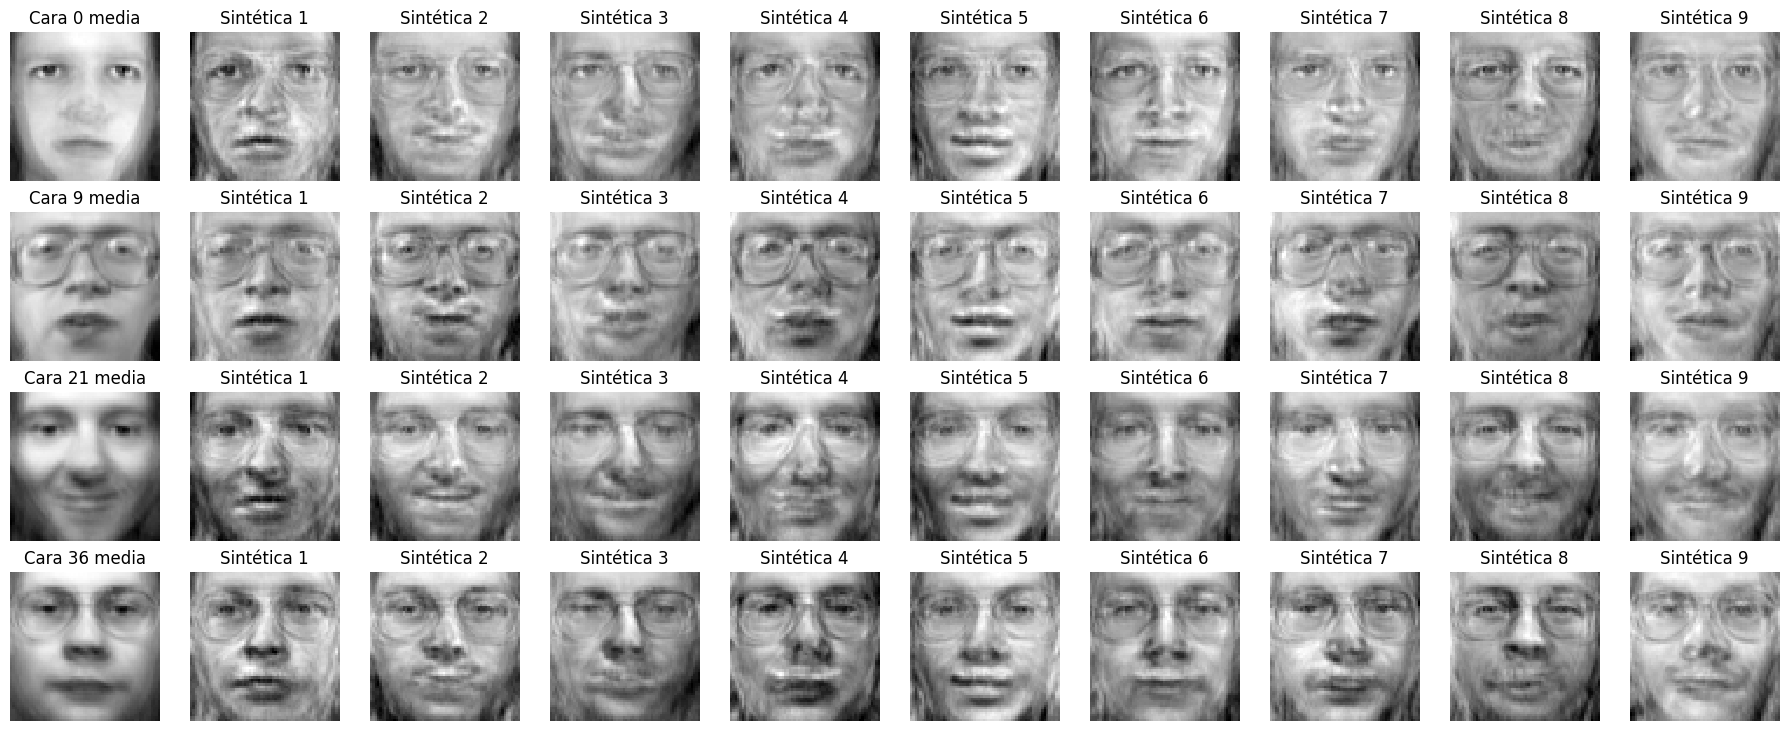

In [14]:
import numpy as np; import matplotlib.pyplot as plt; from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA; from sklearn.datasets import fetch_olivetti_faces
X, y = fetch_olivetti_faces(return_X_y=True); N, D = X.shape
K = 200; pca = PCA(n_components=K).fit(X); X = pca.transform(X)
clf = LinearDiscriminantAnalysis().fit(X, y)
cov = X.T @ X / N - clf.priors_ * clf.means_.T @ clf.means_
cc = [0, 9, 21, 36]; nrows, ncols = len(cc), 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 18*nrows/ncols), constrained_layout=True)
for i, c in enumerate(cc):
    ax = axes.flat[10*i]; ax.set_axis_off(); ax.set_title(f"Cara {c} media")
    mean = pca.inverse_transform(clf.means_[i]).reshape((64, 64))
    ax.imshow(mean, cmap=plt.cm.gray, interpolation="none")
    S = multivariate_normal(mean=clf.means_[i], cov=cov, allow_singular=True, seed=23).rvs(ncols)
    for j in np.arange(1, ncols):
        ax = axes.flat[10*i+j]; ax.set_axis_off(); ax.set_title(f"Sintética {j}")
        synth = pca.inverse_transform(S[j,:]).reshape((64, 64))
        ax.imshow(synth, cmap=plt.cm.gray, interpolation="none")